In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.generate_corrupted_mask import generate_corrupted_mask
from src.generate_exact_distance_matrices import generate_fbm_distance_matrices
from src.frechet import compute_FID
from src.reconstruct_inpainting import InpaintingModel
from src.reconstruct_fista import reconstruct_fista
from src.reconstruct_database_search import reconstruct_database_search
from src.reconstuct_nearest_neighbor import reconstuct_nearest_neighbor

{64: 0, 192: 1, 768: 2, 2048: 3}


/home/alexander/storage/dev/sk_hic/diffusion_fbm/src/reconstruct_inpainting.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(checkp

Total parameters: 113.668609


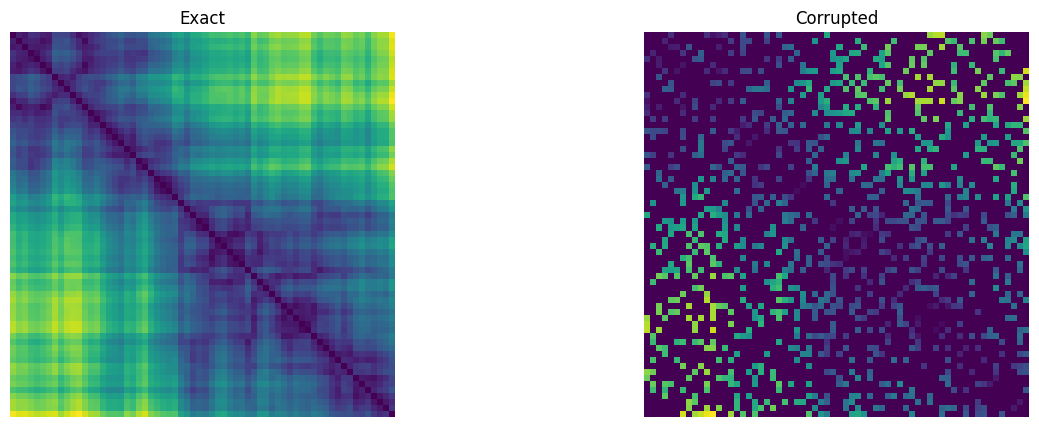

In [ ]:
# Generate the exact distance matrices
dm_exact = generate_fbm_distance_matrices(num_trajectories=1, trajectory_length=64, hurst=1/2)[0]

# Generate the corrupted mask
cm = generate_corrupted_mask(sparsity=0.75, size=64)

# Corrupted distance matrix
dm_corrupted = dm_exact * cm

# Load inpainting model
model_checkpoint = "model_H12_5k_10100.pth" #pretrained diffusion checkpoint 
model = InpaintingModel(model_checkpoint, device='cuda:2')

# Plot the exact and corrupted matrices
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(dm_exact)
plt.title('Exact')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dm_corrupted)
plt.title('Corrupted')
plt.axis('off')
plt.show()

In [ ]:
# Reconstruct using different methods
dm_reconstructed_ddnm_5_3 = model.ddnm(dm_corrupted, cm, device='cuda:0', travel_length=5, travel_repeat=3)[0]
dm_reconstructed_ddnm_1_1 = model.ddnm(dm_corrupted, cm, device='cuda:0', travel_length=1, travel_repeat=1)[0]
dm_reconstructed_fista = reconstruct_fista(dm_corrupted, cm)
dm_reconstruct_nearest_neighbor = reconstuct_nearest_neighbor(dm_corrupted, cm)

# Load database for search method
database = np.load("distance_matrices_train_size_20000.npy") #precomputed database of fbm distance matrices
dm_reconstruct_database_search = reconstruct_database_search(dm_corrupted, cm, database)

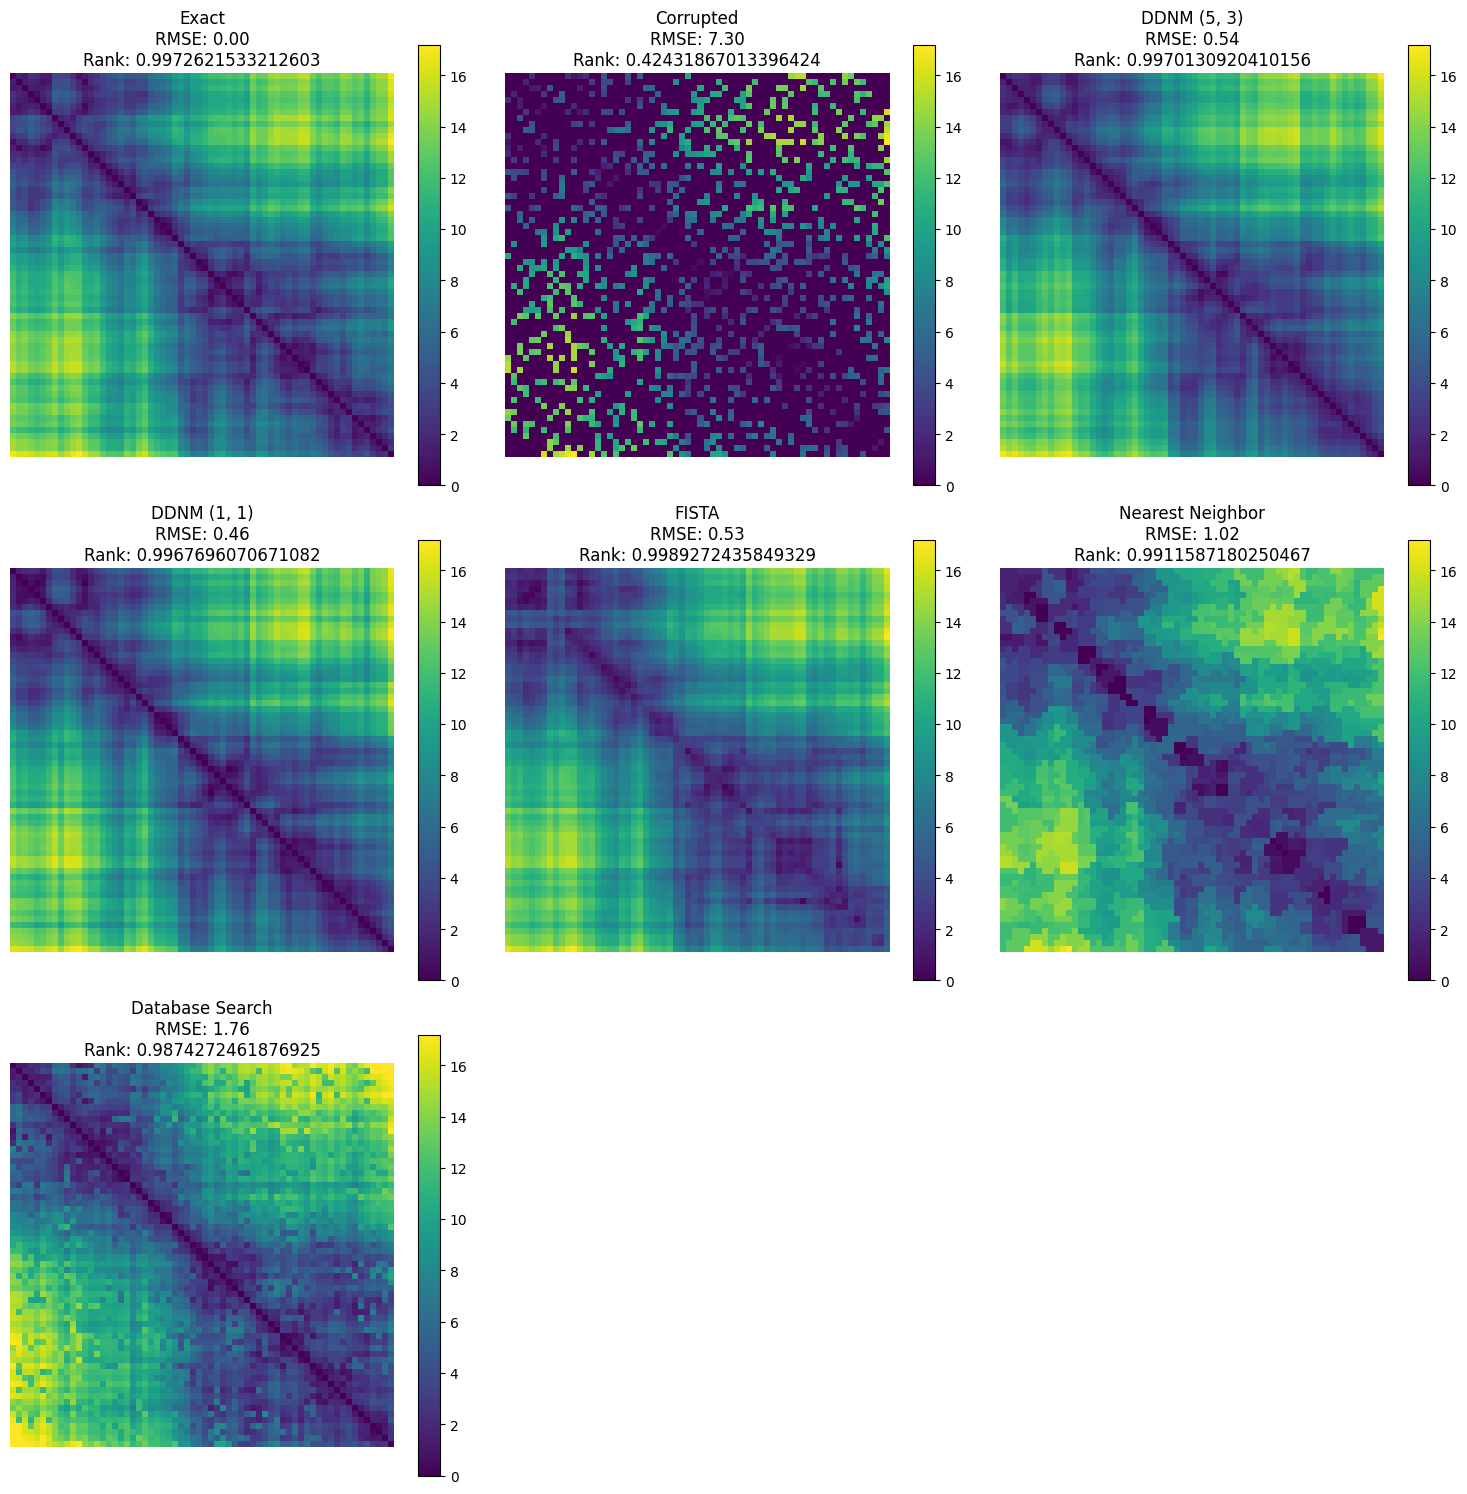

In [9]:
from src.metrics import compute_RMSE
from src.metrics import compute_rank
# Calculate RMSE and rank for each method
methods = {
    'Exact': dm_exact,
    'Corrupted': dm_corrupted,
    'DDNM (5, 3)': dm_reconstructed_ddnm_5_3,
    'DDNM (1, 1)': dm_reconstructed_ddnm_1_1,
    'FISTA': dm_reconstructed_fista,
    'Nearest Neighbor': dm_reconstruct_nearest_neighbor,
    'Database Search': dm_reconstruct_database_search,
}

rmse_results = {}
rank_results = {}

for method, dm in methods.items():
    rmse_results[method] = compute_RMSE(dm_exact, dm)
    rank_results[method] = compute_rank(dm @ dm)

# Set color scale for all images
vmin, vmax = dm_exact.min(), dm_exact.max()

# Plot all reconstructed matrices with RMSE and rank
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over methods to plot them
for i, (method, dm) in enumerate(methods.items()):
    ax = axs[i // 3, i % 3]
    im = ax.imshow(dm, vmin=vmin, vmax=vmax)
    ax.set_title(f'{method}\nRMSE: {rmse_results[method]:.2f}\nRank: {rank_results[method]}')
    ax.axis('off')
    fig.colorbar(im, ax=ax)

# Remove the extra subplot in the 3x3 grid
fig.delaxes(axs[2, 2])
fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()